[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lectures-python/Python_lectures_HW/blob/main/HW/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [1]:
import requests
import pandas as pd
import os
import sqlite3
import ast
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import rcParams
import seaborn as sns

In [2]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 0
        self.limit_ = 1000
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        self.objects_data = None

    def load_ids(self):
        start = False
        current_list = list()
        object_list = list()
        while len(object_list) != 0 or start == False:
            start = True
            paramz = {
                'offset': self.offset_,
                'limit': self.limit_,
                'sortField':'devId.devShortCleanNm',
                'sortType':'asc',
                'objStatus':'0',
            }
            object_list = requests.get(self.url, params=paramz).json().get('data').get('list')
            for object in object_list:
                current_list.append(object.get('objId'))
            self.offset_ += self.limit_
            print(len(current_list))
        self.objects_data = current_list
        
    def get_ids(self):
        return self.objects_data
        
    
    def show_ids(self, count = -1):
        if count == -1:
            print(self.objects_data)
        else:
            print(self.objects_data[0:count])
        


In [3]:
class ObjectInfoExtractor:
    def __init__(self, ids):
        self.data = None
        self.dataFrame = None
        self.ids = ids

    def load_data_url(self):
        data_list = list()
        count = 0
        for objid in self.ids:
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objid}'
            data_list.append(requests.get(url).json().get('data'))
            if (count % 1000 == 0 and count != 0):
                print(count/len(self.ids)*100, "%")
            count += 1
        print("100 %")
        self.data = data_list
        
    def load_data_csv(self, path):
        self.dataFrame = pd.DataFrame(pd.read_csv(path))

    def df_converter(self):
        dataFrame = pd.DataFrame(self.data)
        self.dataFrame = dataFrame
    
    def print_data(self, count = 5):
        print(self.dataFrame.head(count))
        
    def get_dataFrame(self):
        return self.dataFrame

In [21]:
class Saver:
    def __init__(self, data):
        self.data = data

    def save_csv(self, path):
        self.df_csv = self.data.to_csv(f'{path}', index=False, encoding="utf-8-sig")

    def save_pickle(self, path):
        self.df_pick = self.data.to_pickle(f'{path}')

class Visualizer:
    def __init__(self, data):
        self.dataFrame = data
        self.regionList = None
        self.region()
        
    def region(self):
        url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/сервисы/api/dictionary/regions'
        self.regionList = requests.get(url).json()

    def make_plotAvgPrice(self):
        avgPrice = {}
        for reg in self.regionList:
            row = dict({'name' : reg['name'],'avg': 0, 'sum' : 0, 'count' : 0})
            avgPrice[reg['id']] = row
        for obj in self.dataFrame.iterrows():
            if not pd.isna(obj[1]['objPriceAvg']):
                row = avgPrice[obj[1]['region']]
                row['sum'] += obj[1]['objPriceAvg']
                row['count'] += 1
                row['avg'] = row['sum']/row['count']
        df_price = pd.DataFrame(avgPrice).T
        price_series = df_price.set_index('name')['avg']
        rcParams['figure.figsize'] = 10,20
        plt.title('Средняя цена за квадратный метр по регионам')
        plt.xlabel('Цена')
        plt.ylabel('Регионы', rotation=90)
        price_series.sort_values(ascending=True).plot(kind='barh')
        plt.show()

    def make_plotVolumeInRegion(self):
        volume = {}
        for reg in self.regionList:
            row = dict({'name' : reg['name'], 'count' : 0})
            volume[reg['id']] = row
        for obj in self.dataFrame.iterrows():
            row = volume[obj[1]['region']]
            row['count'] += 1
        df_volume = pd.DataFrame(volume).T
        volume_series = df_volume.set_index('name')['count']
        rcParams['figure.figsize'] = 10,20
        plt.title('Объемы строящихся домов по регионам')
        plt.xlabel('Количество строящихся домов')
        plt.ylabel('Регионы', rotation=90)
        volume_series.sort_values(ascending=True).plot(kind='barh')
        plt.show()
        
    def make_subplotsStatisticsYear(self):
        statisticsYear = {}
        for obj in self.dataFrame.iterrows():
            row = int(obj[1]['objReady100PercDt'][:4])
            count = statisticsYear[row] if row in statisticsYear.keys() else 1
            statisticsYear[row] = count+1
        df_years = pd.DataFrame(list(statisticsYear.items()), columns=['year', 'count'])
        df_years = df_years.sort_values('year')
        rcParams['figure.figsize']= 14.5,5
        fig, ax = plt.subplots()
        ax.plot(df_years['year'], df_years['count'], color = 'r', linewidth = 3)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(400))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(200))
        plt.title('Количество введенных в эксплуатацию домов по годам')
        plt.xlabel('Год введенния в эксплуатацию')
        plt.ylabel('Количество домов', rotation=90)
        ax.grid(which='major', color = 'k')
        ax.minorticks_on()
        ax.grid(which='minor', color = 'gray', linestyle = ':')
        fig.set_figwidth(17)
        fig.set_figheight(7)
        plt.show()
    
    def make_plotStatisticsFloor(self):
        statisticsFloor = {}
        for obj in self.dataFrame.iterrows():
            if not pd.isna(obj[1]['floorMax']):
                row = int(obj[1]['floorMax'])
                count = statisticsFloor[row] if row in statisticsFloor.keys() else 1
                statisticsFloor[row] = count+1
        df_floor = pd.DataFrame(list(statisticsFloor.items()), columns=['floor', 'count'])
        df_floor1 = df_floor.sort_values('count')[int(len(df_floor)/2):]
        df_floor2 = df_floor.sort_values('count')[0:int(len(df_floor)/2)]
        floor_series1 = df_floor1.set_index('floor')['count']
        floor_series2 = df_floor2.set_index('floor')['count']
        plt.title('Количество строящихся домов по этажам')
        plt.xlabel('Количество домов')
        plt.ylabel('Количество этажей', rotation=90)
        rcParams['figure.figsize'] = 20,15
        floor_series1.sort_values(ascending=True).plot(kind='barh')
        plt.show()
        plt.title('Количество строящихся домов по этажам')
        plt.xlabel('Количество домов')
        plt.ylabel('Количество этажей', rotation=90)
        floor_series2.sort_values(ascending=True).plot(kind='barh')
        plt.show()
        
    def make_subplotsAvgMaxFloot(self):
        avgFloor = {}
        for reg in self.regionList:
            row = dict({'name' : reg['name'], 'avg': 0, 'sum' : 0, 'count' : 0})
            avgFloor[reg['id']] = row
        for obj in self.dataFrame.iterrows():
            if not pd.isna(obj[1]['floorMax']):
                row = avgFloor[obj[1]['region']]
                row['sum'] += obj[1]['floorMax']
                row['count'] += 1
                row['avg'] = row['sum']/row['count']
        df_floorAvg = pd.DataFrame(avgFloor).T
        df_floorAvg = df_floorAvg.sort_values('avg')
        fig, ax = plt.subplots(figsize=(20,10))
        plt.title('8 регионов у которых наибольшая средняя этажность строящихся домов')
        plt.xlabel('Регионы')
        plt.ylabel('Средняя этажность', rotation=90)
        chart1 = ax.bar(df_floorAvg['name'][-8:], df_floorAvg['avg'][-8:])
    
    def make_scatterStatisticsFlat(self):
        statisticsFlat = {}
        for obj in self.dataFrame.iterrows():
            #Намерено не будем сохранять дома с количеством квартир равным нулю
            if not pd.isna(obj[1]['objElemLivingCnt']) and obj[1]['objElemLivingCnt'] != 0:
                row = int(obj[1]['objElemLivingCnt'])
                count = statisticsFlat[row] if row in statisticsFlat.keys() else 1
                statisticsFlat[row] = count+1
        df_flat = pd.DataFrame(list(statisticsFlat.items()), columns=['flat', 'count'])
        df_flat = df_flat.sort_values('flat')
        plt.scatter(df_flat['flat'],df_flat['count'])
        plt.title('Количество домов с определенным количеством квартир')
        plt.xlabel('Количество квартир в доме')
        plt.ylabel('Количество домов', rotation=90)
        plt.show()
        
    def make_pieAreaByRegion(self):
        SumSquare = {}
        for reg in self.regionList:
            row = dict({'name' : reg['name'], 'sum' : 0, 'count' : 0})
            SumSquare[reg['id']] = row
        for obj in self.dataFrame.iterrows():
            if not pd.isna(obj[1]['objSquareLiving']):
                row = SumSquare[obj[1]['region']]
                row['sum'] += obj[1]['objSquareLiving']
                row['count'] += 1
        df_square = pd.DataFrame(SumSquare).T
        df_square = df_square.sort_values('sum')
        wedge_properties = {"edgecolor":"k",'linewidth': 1}
        plt.pie(df_square['sum'], labels=df_square['name'], startangle=90,
                   counterclock=False, shadow=True, wedgeprops=wedge_properties,
                   autopct="%1.1f%%", pctdistance=0.9)
        plt.title("Жилая площадь по регионам")
        plt.show()
        
    def make_relplotParkingPrice(self):
        statisticsParkingPrice = {}
        for obj in self.dataFrame.iterrows():
            parkPrice = str(obj[1]['objElemParkingCnt']) + " " + str(obj[1]['objPriceAvg'])
            count = statisticsParkingPrice[parkPrice] if parkPrice in statisticsParkingPrice.keys() else 1
            statisticsParkingPrice[parkPrice] = count+1
        df_parkingPrice = pd.DataFrame(columns = ['parking', 'price', 'count'])
        for item in statisticsParkingPrice.items():
            parking, price = item[0].split()
            parking, price = float(parking), float(price)
            if not pd.isna(parking) and not pd.isna(price) and parking != 0 and price != 0:
                row = pd.DataFrame([{'parking' : parking, 'price' : price, 'count' : item[1]}])
                df_parkingPrice = pd.concat([df_parkingPrice, row], ignore_index=True)
        df_parkingPrice = df_parkingPrice.sort_values('parking')
        sns.set_theme(style="whitegrid")
        cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
        g = sns.relplot(
            data=df_parkingPrice,
            x="parking", y="price", size="count",
            palette=cmap, sizes=(20, 200), height=15,
        )
        g.ax.xaxis.grid(True, "minor", linewidth=.25)
        g.ax.yaxis.grid(True, "minor", linewidth=.25)
        g.despine(left=True, bottom=True)

In [5]:
dL = DomIdLoader()
dL.load_ids()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
10594
10594


In [6]:
dL.show_ids(20)

[29679, 13383, 13397, 13399, 13398, 13391, 36912, 44076, 27476, 10891, 39176, 39174, 39175, 27049, 41421, 41420, 30292, 19457, 18708, 18709]


In [7]:
objExt = ObjectInfoExtractor(dL.get_ids())

In [8]:
objExt.load_data_url()
objExt.df_converter()

9.439305267132339 %
18.878610534264677 %
28.317915801397014 %
37.757221068529354 %
47.196526335661694 %
56.63583160279403 %
66.07513686992638 %
75.51444213705871 %
84.95374740419105 %
94.39305267132339 %
100 %


In [9]:
#objExt.load_data_csv("C:\\учеба\\Магистратура\\Python\\Python\\HomeWork1\\df_csv.csv")

In [10]:
objExt.print_data(1)

      id    pdId                                          developer  region  \
0  29679  124647  {'devId': 7424, 'devShortCleanNm': '212-2', 'd...      61   

      address  objElemLivingCnt objReady100PercDt wallMaterialShortDesc  \
0  г Таганрог                18        2020-03-31                Другое   

  objLkFinishTypeDesc objLkFreePlanDesc  ...  generalContractorNm  \
0            Под ключ              Есть  ...                  NaN   

   nonlivFirstFloor objLkSaleDepEmail transportDistIndex  \
0               NaN               NaN                NaN   

  transportDistIndexValue nameObj greenAreaIndexValue  airQualityIndexValue  \
0                     NaN     NaN                 NaN                   NaN   

   complexShortNm metro  
0             NaN   NaN  

[1 rows x 67 columns]


In [11]:
save = Saver(objExt.get_dataFrame())
save.save_csv("C:\\учеба\\Магистратура\\Python\\Python\\HomeWork1\\df_csv.csv")
save.save_pickle("C:\\учеба\\Магистратура\\Python\\Python\\HomeWork1\\df_pickle.p")

In [22]:
vis = Visualizer(objExt.get_dataFrame())

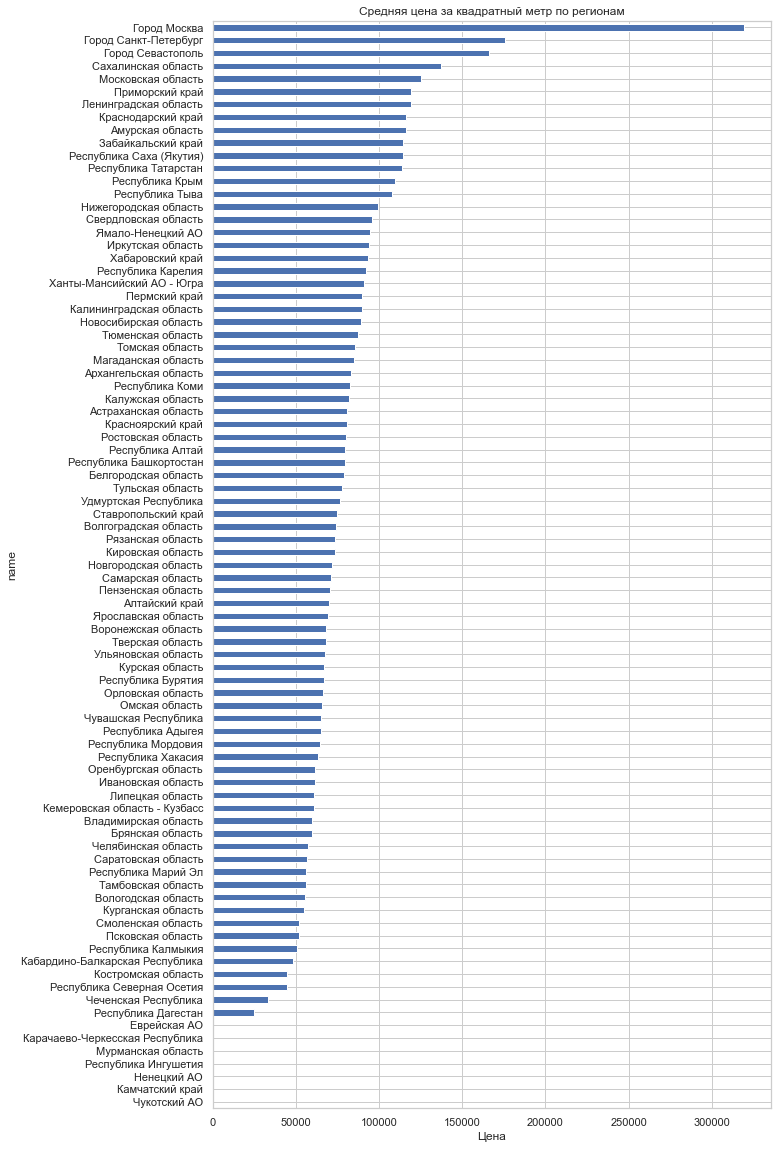

In [23]:
vis.make_plotAvgPrice()

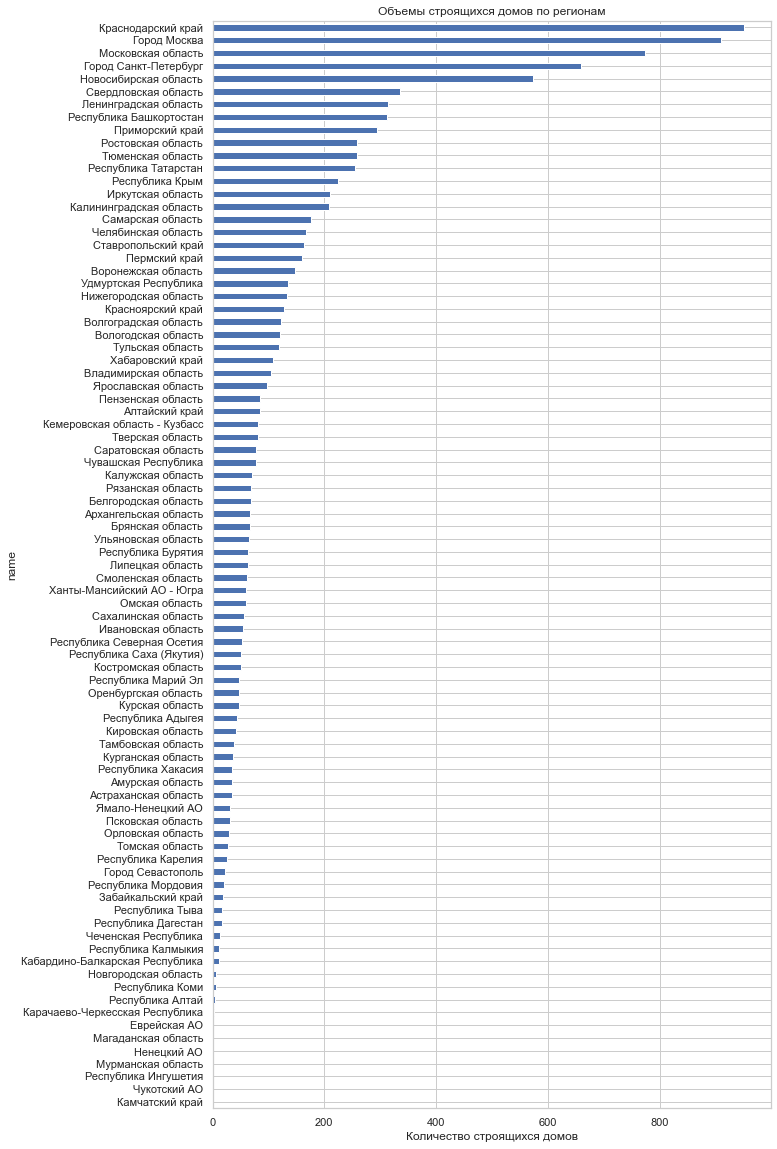

In [24]:
vis.make_plotVolumeInRegion()

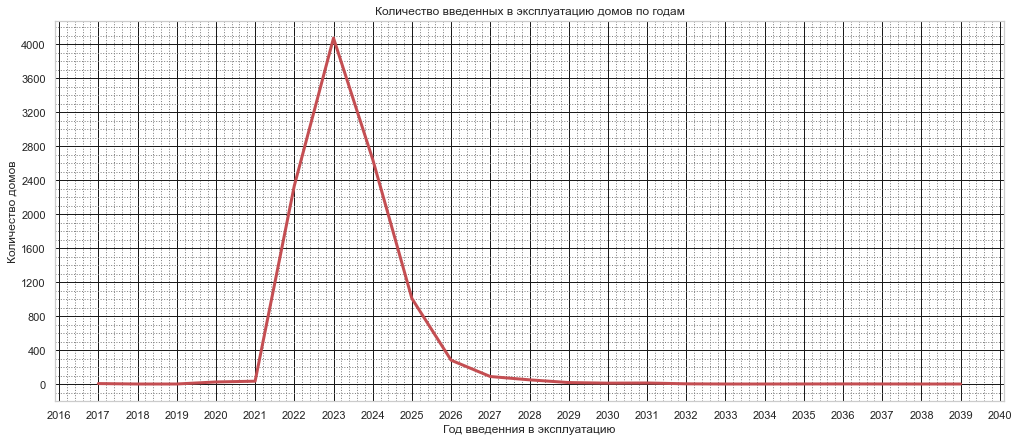

In [25]:
vis.make_subplotsStatisticsYear()

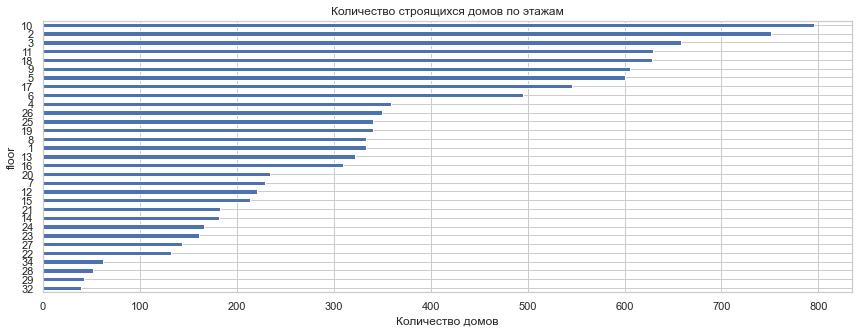

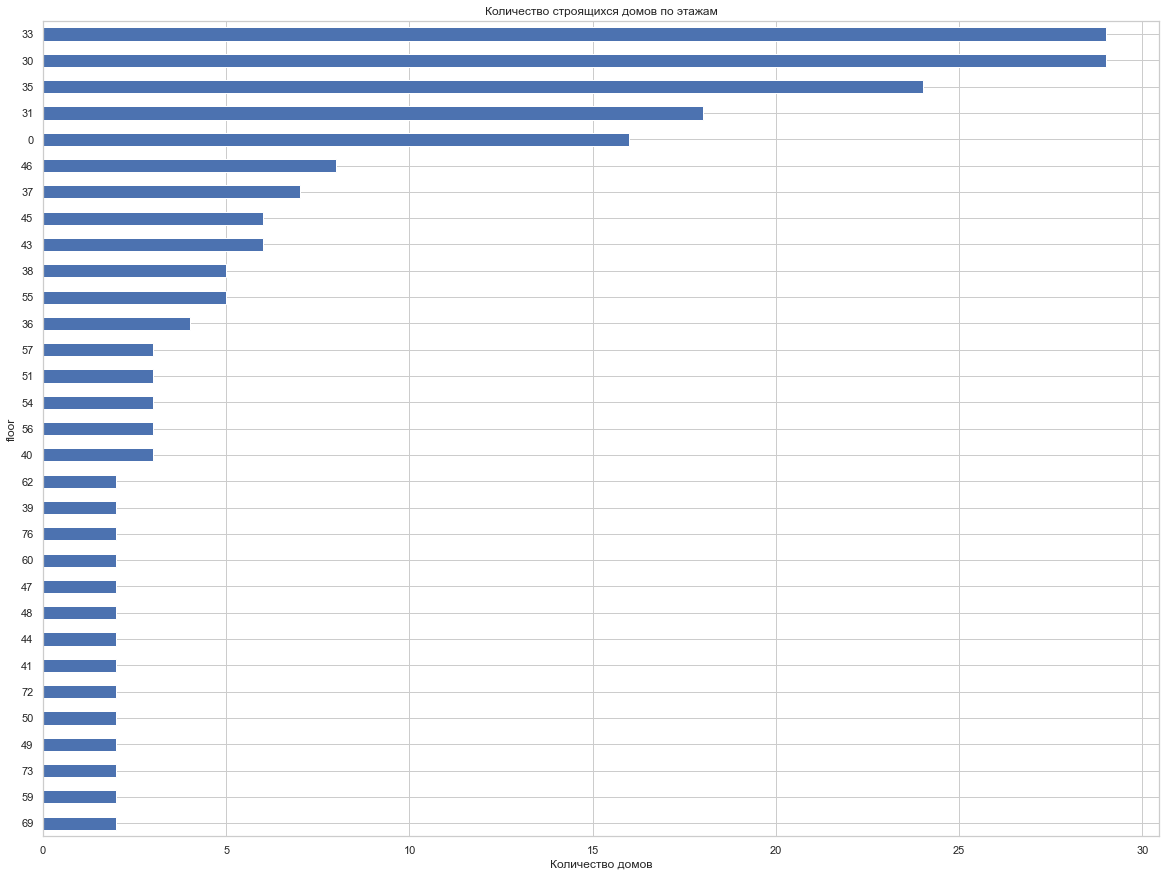

In [26]:
vis.make_plotStatisticsFloor()

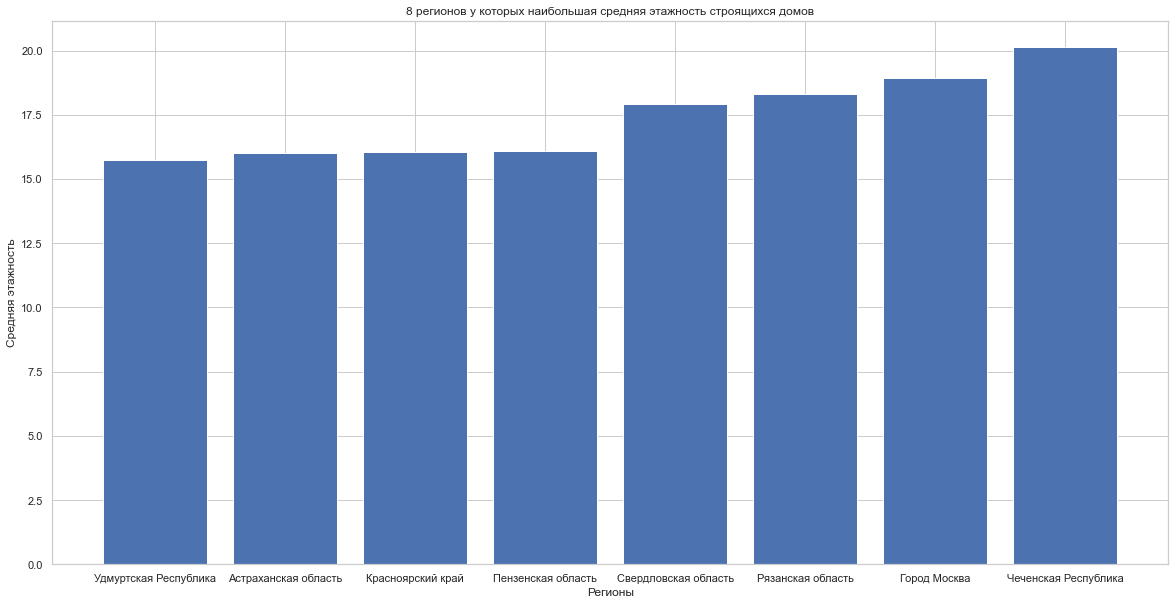

In [27]:
vis.make_subplotsAvgMaxFloot()

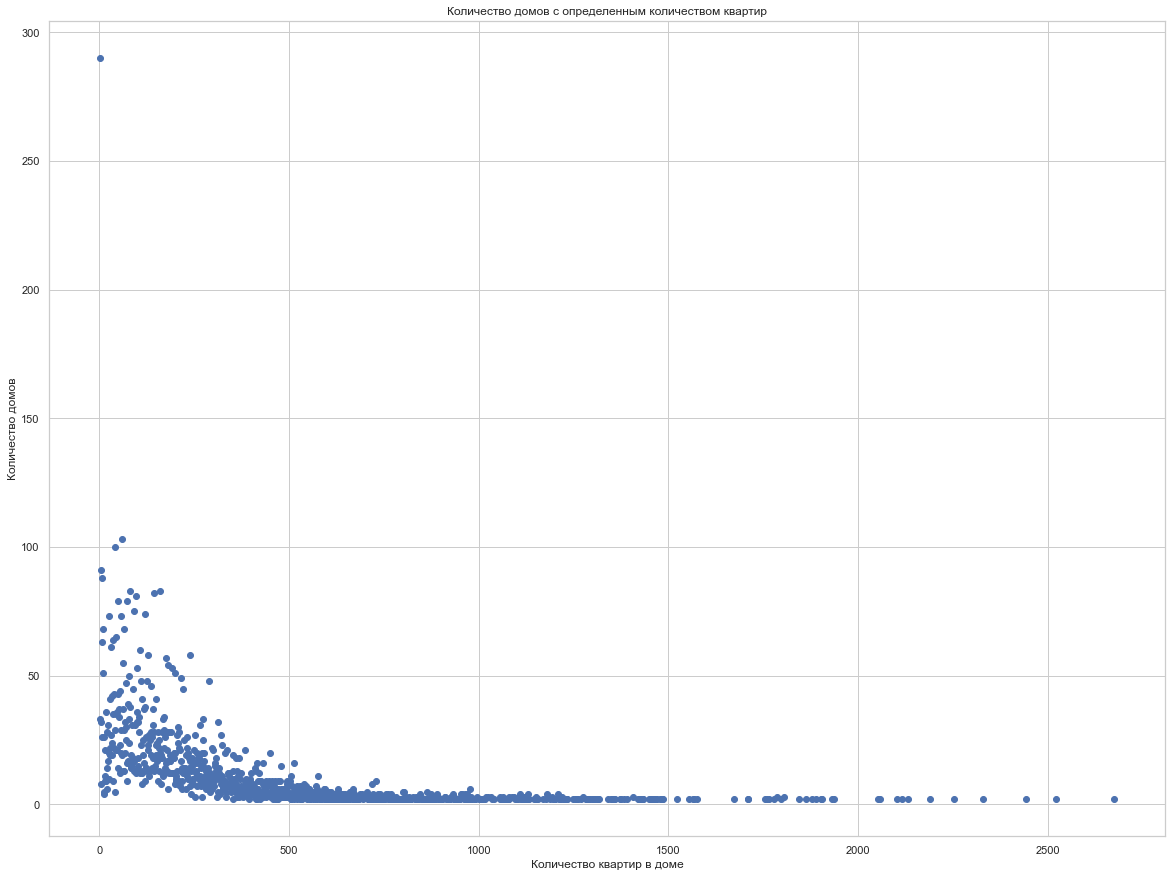

In [28]:
vis.make_scatterStatisticsFlat()

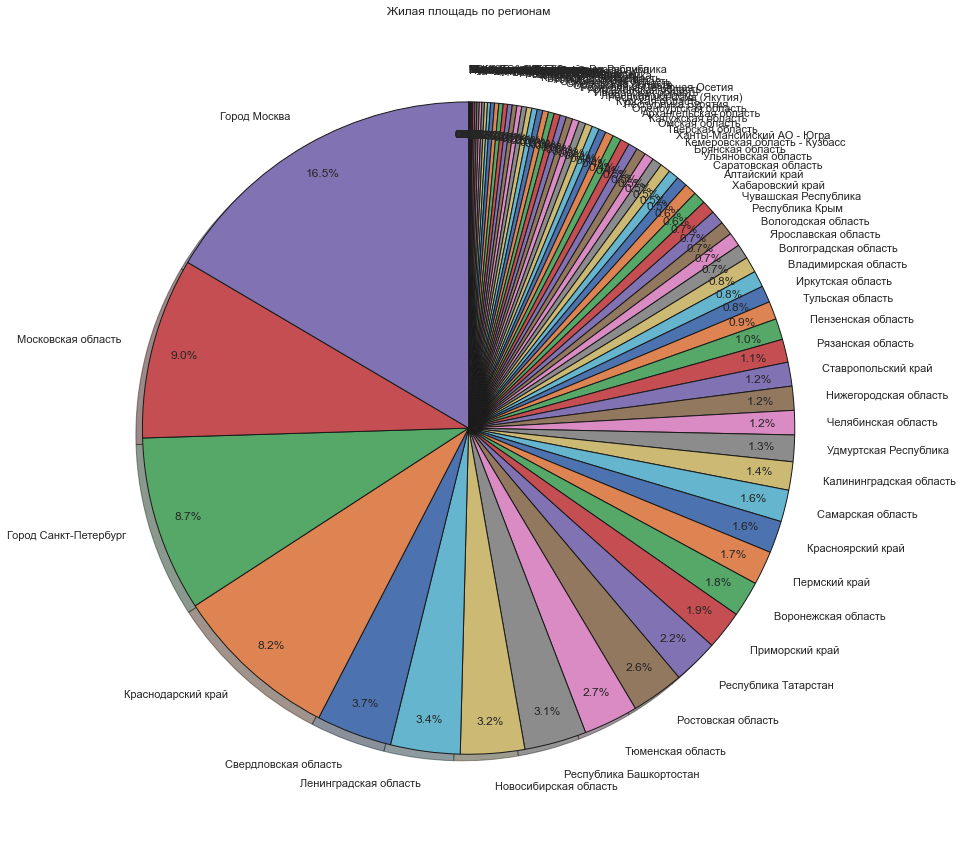

In [29]:
vis.make_pieAreaByRegion()

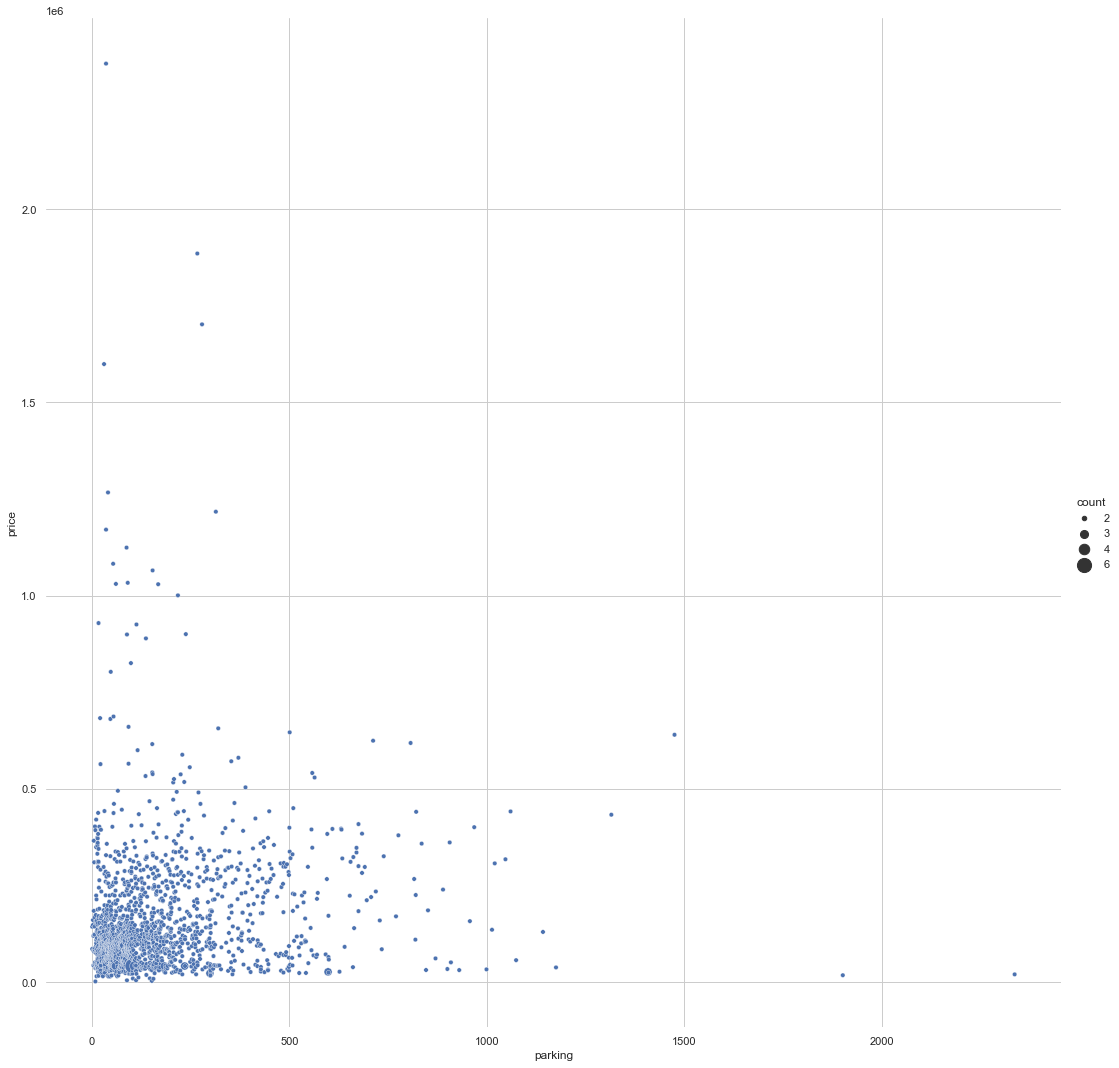

In [30]:
vis.make_relplotParkingPrice()